# Proyecto 6: proyecto integrado


## Preambulo; se cargan librerias y se declara la funcion de exploracion

In [1]:
#cargamos las librerias a ser utilizadas durante el proyecto y Creamos una funcion para poder hacer mas facil la exploracion 

import numpy as np
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
import sidetable as stb
import seaborn as sns
sns.set_theme(rc={"figure.figsize": (15,10)})

def looks(datos):
    print("Se ejecuta la descripcion de los datos:")
    print(datos.describe(include= "all"))
    print()
    print("se hace exploracion con metodo info:")
    datos.info()
    print()
    print("se hace una observacion con el metodo Head:")
    print(datos.head())
    print()
    print("hay NA?:")
    print(datos.isna().sum())
    print()
    print("Duplicados:")
    print(datos.duplicated().sum())

## Parte 1 & 2
### ETL

In [2]:
# Cargamos los datos
games = pd.read_csv("datasets/games.csv")
#games # se verifica la lectura es correcta

In [3]:
looks(games)


Se ejecuta la descripcion de los datos:
                               Name Platform  Year_of_Release   Genre  \
count                         16713    16715     16446.000000   16713   
unique                        11559       31              NaN      12   
top     Need for Speed: Most Wanted      PS2              NaN  Action   
freq                             12     2161              NaN    3369   
mean                            NaN      NaN      2006.484616     NaN   
std                             NaN      NaN         5.877050     NaN   
min                             NaN      NaN      1980.000000     NaN   
25%                             NaN      NaN      2003.000000     NaN   
50%                             NaN      NaN      2007.000000     NaN   
75%                             NaN      NaN      2010.000000     NaN   
max                             NaN      NaN      2016.000000     NaN   

            NA_sales      EU_sales      JP_sales   Other_sales  Critic_Score  \
cou

In [4]:
#se usa sidetable para obtener el porcentaje de datos nulos por columna
games.stb.missing(style= True)

,missing,total,percent
Critic_Score,"8,578","16,715",51.32%
Rating,"6,766","16,715",40.48%
User_Score,"6,701","16,715",40.09%
Year_of_Release,269,"16,715",1.61%
Name,2,"16,715",0.01%
Genre,2,"16,715",0.01%
Platform,0,"16,715",0.00%
NA_sales,0,"16,715",0.00%
EU_sales,0,"16,715",0.00%
JP_sales,0,"16,715",0.00%


Encontramos que hay NA en 
- 2 en nombre (no hay ninguna info de ello, se decide eliminar)
- 369 en año de lanzamiento (Se observa que son datos desconocidos, se establece un dato como 0)
- 2 en genero (Se observa que son datos desconocidos, se establece un dato generico)

Debido a la gran cantidad de datos perdidos (superior al 10%) se decide no tocar ni remplazar datos que podrian perjudicar mas que beneficiar al asignarse un dato arbitrario en la imputacion. 

Las columnas que presentan esto son:
- 8578 en critic score 
- 6701 en user score 
- 6766 en rating 

Es posible que estas ausencias se deban a temas de coleccion de datos o, en el caso de los usuarios seleccionaron en el cuestionario NA o simplemente no se recolectaron datos para algun juego en particular.

Salta a la vista que sean tantos, lo correcto seria acudir con el dueño de los datos y presentar esto para obtner mas informacion en caso de existir y notificar para que este enterado

Al momento de hacer analisis se excluiran los valores nulos de la columna en particular de requerirse. 

In [5]:
#Se observa que hay mayusculas en los nombres se convierte todo a minusculas para estandarizar
games.columns = games.columns.str.lower()


#correcciones de los datos:
games["year_of_release"] = games["year_of_release"].fillna(0).astype("int")
games["name"] = games["name"].fillna("Desconocido")
games["genre"] = games["genre"].fillna("Desconocido")
games["rating"] = games["rating"].fillna("Desconocido")
#se remplazan los tbd por NA para poder convertir la columna a float y poder hacer calculos con ella
games.loc[games["user_score"]== "tbd","user_score"] = np.nan
games["user_score"] = games["user_score"].astype("float")
games["gbl_sales"] = games["eu_sales"] + games["na_sales"] + games["jp_sales"] + games["other_sales"]

In [6]:
#Celda para hacer la exploracion indivudual de las columnas con valores perdidos y entender mas el contexto del mismo. 
# Va abajo de las correcciones por practicidad al momento de hacer los movimientos

#games[games["user_score"].isna()]
#games["user_score"].value_counts()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,gbl_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Desconocido,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Desconocido,31.38


## Parte 3
### Analisis de los datos

 Mira cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?

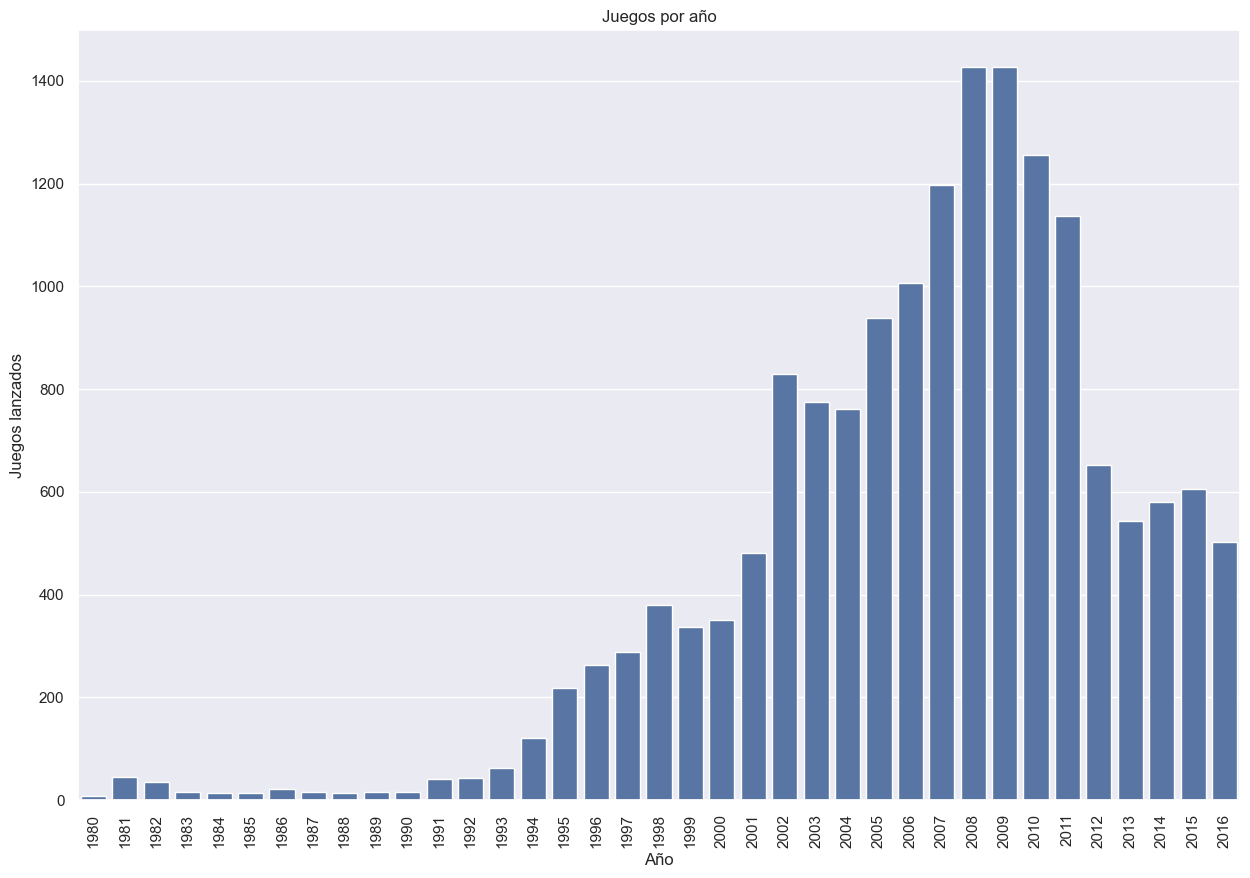

In [7]:
#se hace una exploracion de juegos por año
per_year = games[games["year_of_release"]!=0].pivot_table(index= ["year_of_release"], values= "name", aggfunc= "count")
graf1 = sns.barplot(data= per_year.reset_index(), x="year_of_release",y="name")
plt.xticks(rotation=90)
graf1.set(title="Juegos por año", xlabel='Año', ylabel='Juegos lanzados')
plt.show()
#print(per_year)

- Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elige varias plataformas potencialmente rentables.
- Observa cómo varían las ventas de una plataforma a otra. Elige las plataformas con las mayores ventas totales y construye una distribución basada en los datos de cada año. Busca las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?
-   Determina para qué período debes tomar datos**.**  Para hacerlo mira tus respuestas a las preguntas anteriores. Los datos deberían permitirte construir un modelo para 2017.

In [8]:
sales_per_plat = games.pivot_table(index= ["platform"], values= "gbl_sales", aggfunc= "sum")
sales_per_plat = sales_per_plat.reset_index().sort_values("gbl_sales",ascending=False)
print(sales_per_plat.head(10))

   platform  gbl_sales
16      PS2    1255.77
28     X360     971.42
17      PS3     939.65
26      Wii     907.51
4        DS     806.12
15       PS     730.86
6       GBA     317.85
18      PS4     314.14
19      PSP     294.05
13       PC     259.52


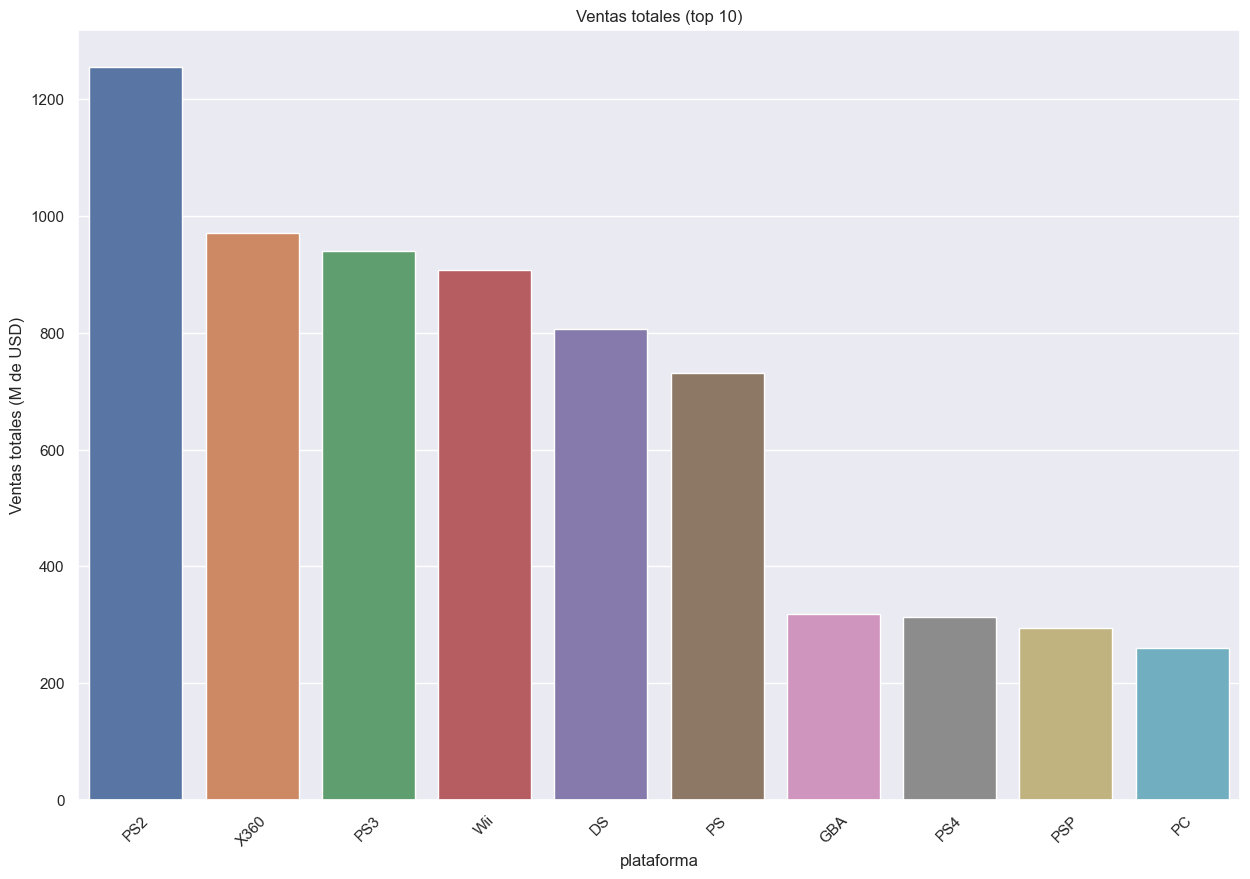

In [9]:
graf2 = sns.barplot(data= sales_per_plat.head(10), x="platform",y="gbl_sales",hue="platform")
plt.xticks(rotation=45)
graf2.set(title="Ventas totales (top 10)", xlabel='plataforma', ylabel='Ventas totales (M de USD)')
plt.show()


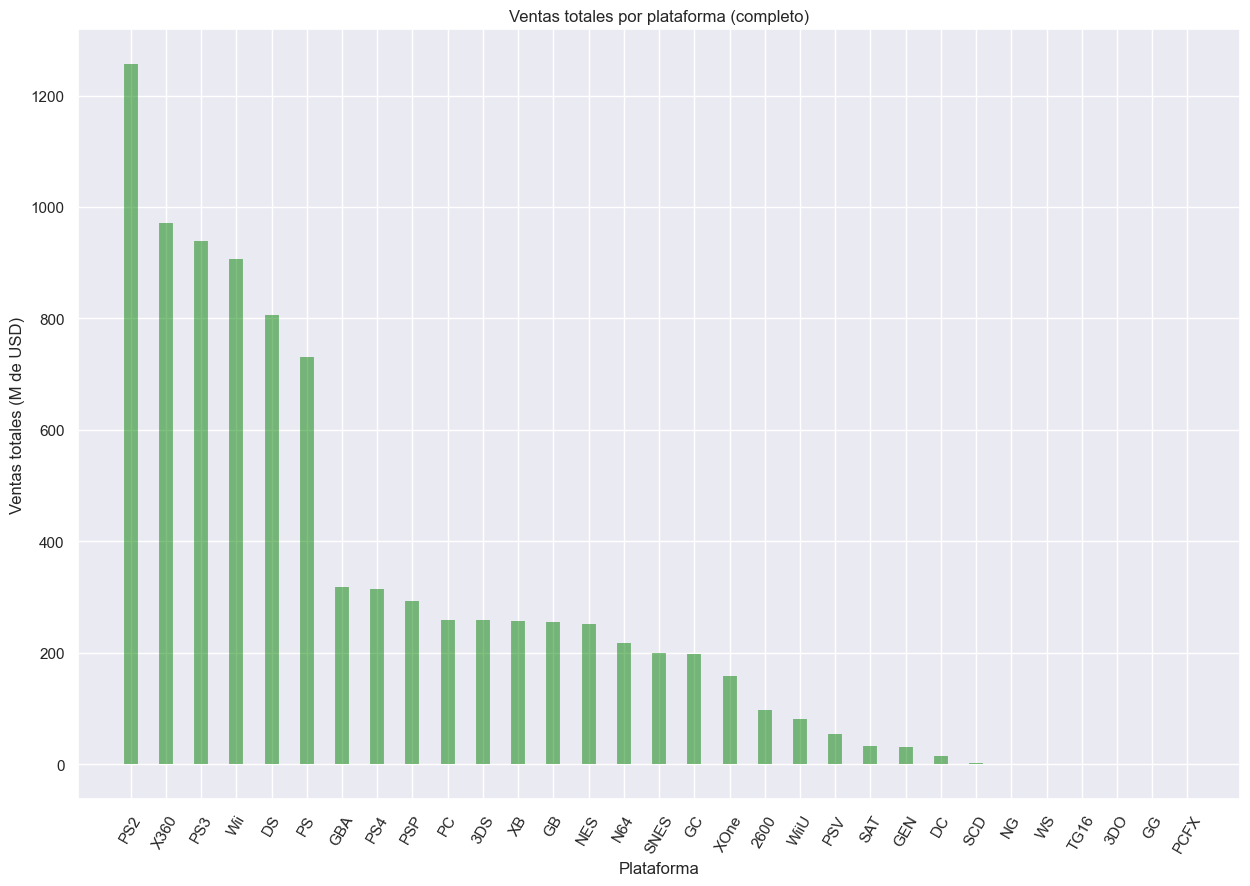

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
ax.vlines(x=sales_per_plat.platform, ymin=0, ymax= sales_per_plat.gbl_sales, alpha=0.5, linewidth=10, color="green")
ax.set_xticks(sales_per_plat.platform)
ax.set_xticklabels(sales_per_plat.platform, rotation=60)
ax.set_title("Ventas totales por plataforma (completo)")
ax.set_xlabel("Plataforma")
ax.set_ylabel("Ventas totales (M de USD)")
plt.show()

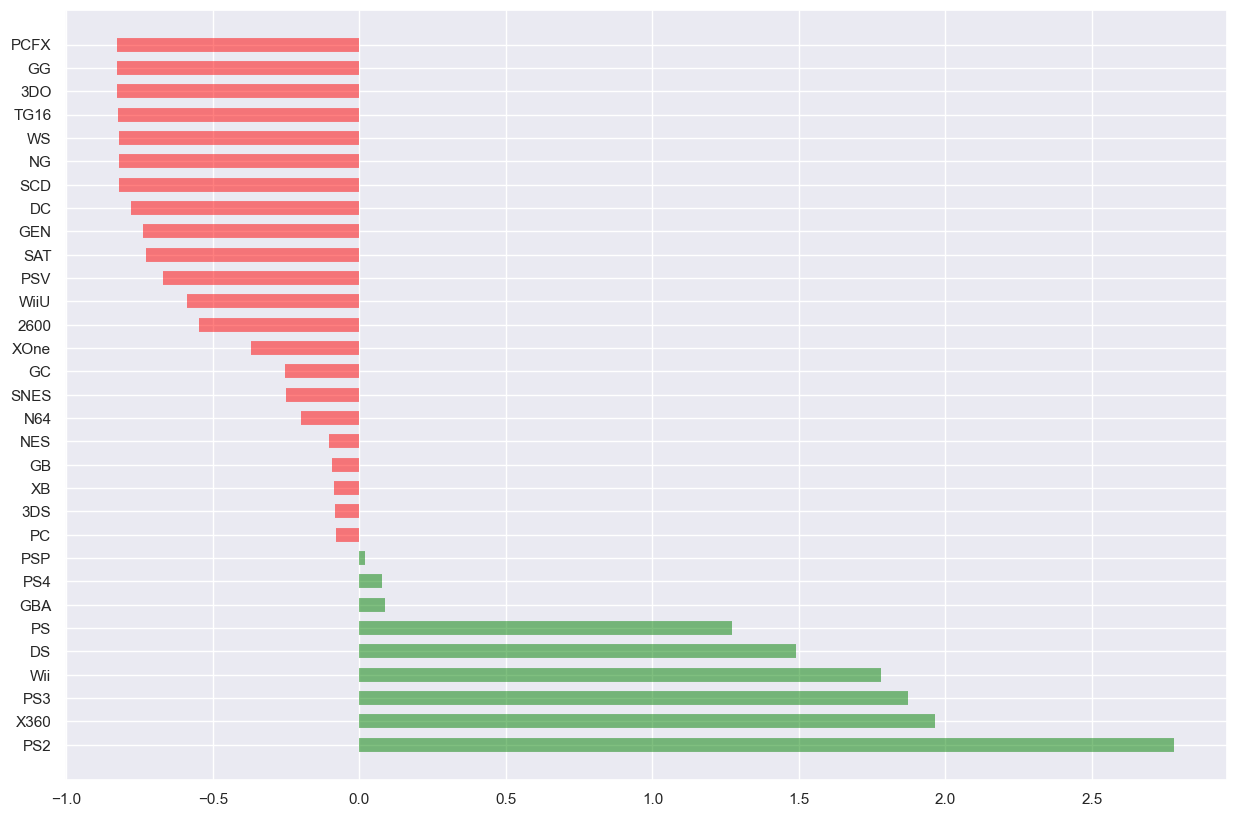

In [11]:
#Comparacion de ventas, para ver que plataformas son mas rentables por encima de la media de ventas global.
sales_per_plat["zscore"] =(sales_per_plat["gbl_sales"] - sales_per_plat["gbl_sales"].mean()) / sales_per_plat["gbl_sales"].std()
sales_per_plat["color"] = ["red" if puntaje <0 else "green" for puntaje in sales_per_plat["zscore"]]

plt.figure(figsize= (15,10))
plt.hlines(
    y=sales_per_plat.platform,
    xmax=sales_per_plat.zscore,
    xmin=0,
    linewidth = 10,
    alpha = 0.5,
    color=sales_per_plat.color
)
plt.show()

Se observa que la mayo rentabilidad de las consolas son PS2, X360, PS3, WII, DS & PS. Para los analisis futuros se seleccionaran esas 6 consolas.

In [12]:
dat_05adv = games[games.year_of_release >= 2006]
pltfm_filt = ["PS2", "X360", "PS3", "Wii", "DS", "PS"]
dat_05adv_pltfrm = dat_05adv.query("platform in @pltfm_filt")
#seleccionamos solo los datos de 2006 en adelante para futuros analisis y generar los estadisticos

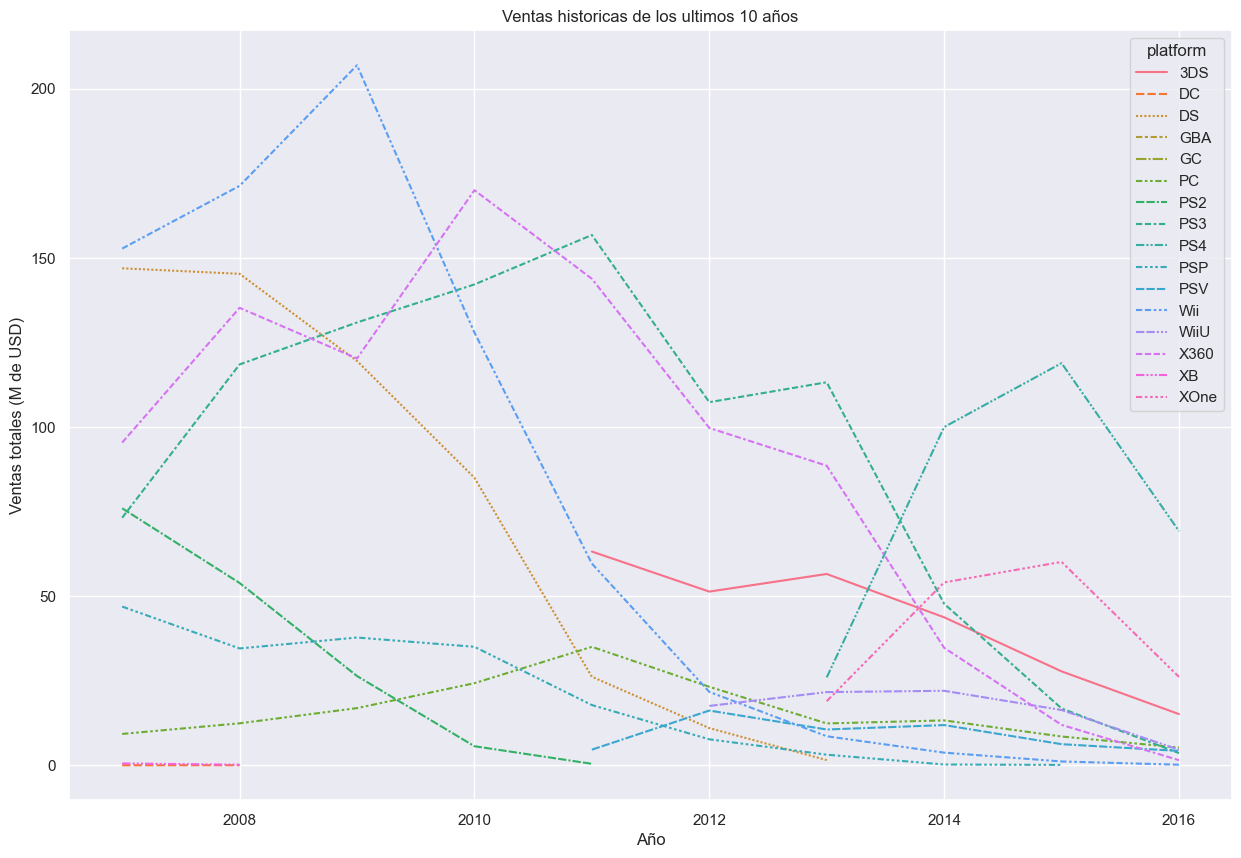

In [31]:
#Se hace un historico de ventas desde el año 2005 


vnts_x_tiempo = dat_05adv.pivot_table(index= "year_of_release", columns= "platform", values="gbl_sales", aggfunc="sum")
vnts_x_tiempo = vnts_x_tiempo.iloc[1:,:]
graf3 = sns.lineplot(data=vnts_x_tiempo)
graf3.set(title="Ventas historicas de los ultimos 10 años", xlabel='Año', ylabel='Ventas totales (M de USD)')
plt.show()

Se observa que la mayoria de las consolas tienen un tiempo de vida de apoximadamente 10 años.

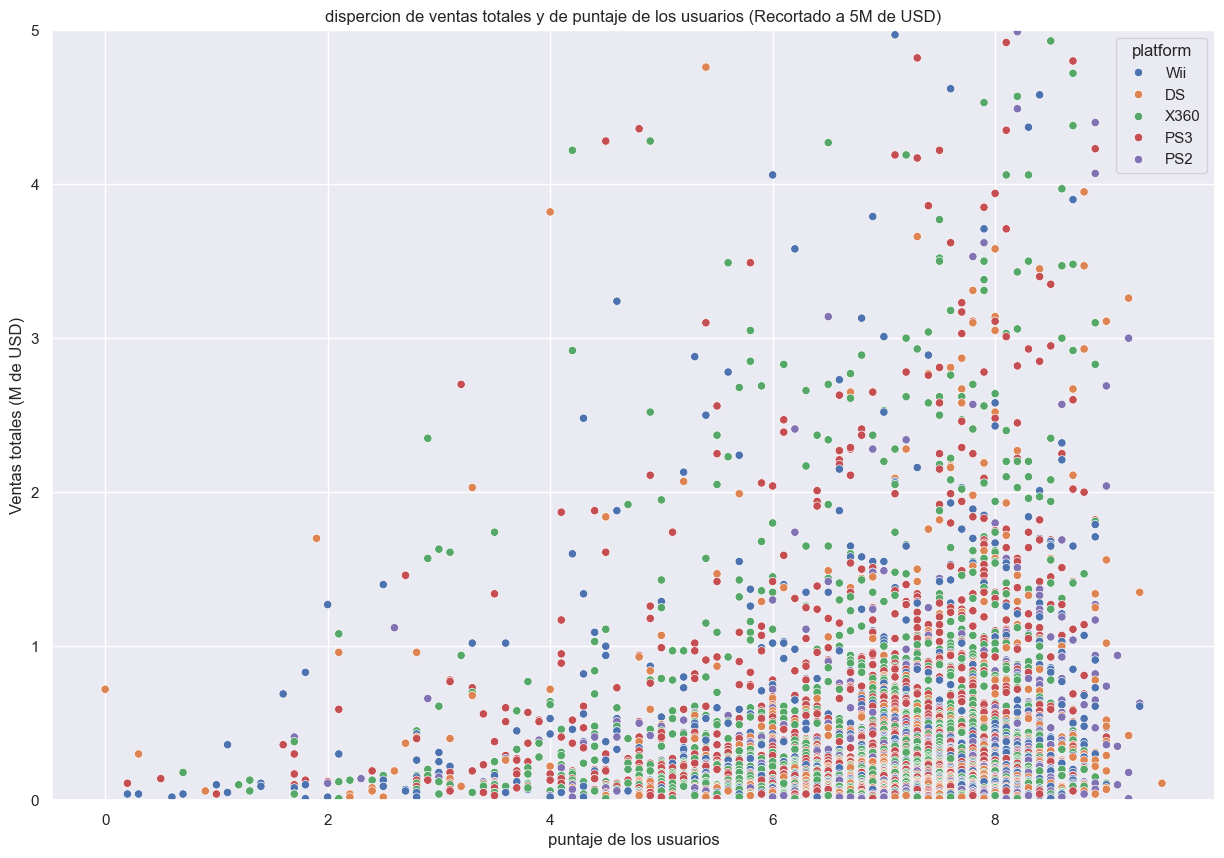

La covarianza es de:  3.2819313482281105


In [28]:
graf4 = sns.scatterplot(data=dat_05adv_pltfrm, x= "user_score", y= "gbl_sales", hue= "platform")
graf4.set(ylim=(0, 5))
#plt.xticks(rotation=45)
graf4.set(title="dispercion de ventas totales y de puntaje de los usuarios (Recortado a 5M de USD)", xlabel='puntaje de los usuarios', ylabel='Ventas totales (M de USD)')
plt.show()

print("La covarianza es de: ",np.cov(dat_05adv_pltfrm["user_score"], dat_05adv_pltfrm["gbl_sales"])[1,1])

Se observa en este grafico, el cual fue recortado para fines de presentacion a un valor de 5M de USD, que existe una aparente tendencia a que mientras mejor puntuado este un juego por los usuarios, mas ventas tendra.

Aunque la covarianza de los mismos es muy poca se observa una relacion positiva tenue al respecto 

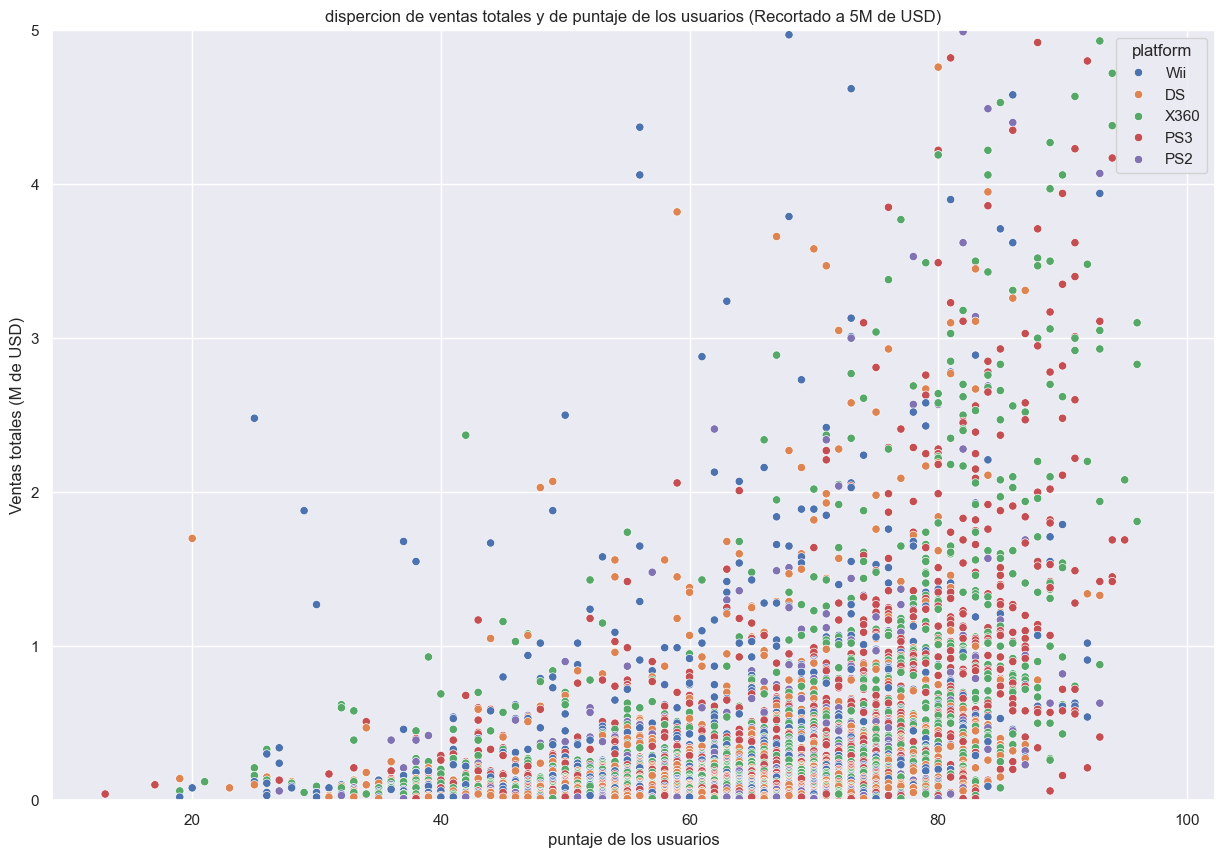

La covarianza es de:  3.2819313482281105


In [ ]:
graf5 = sns.scatterplot(data=dat_05adv_pltfrm, x= "critic_score", y= "gbl_sales", hue= "platform")
graf5.set(ylim=(0, 5))
#plt.xticks(rotation=45)
graf5.set(title="dispercion de ventas totales y de puntaje de la critica (Recortado a 5M de USD)", xlabel='puntaje de la critica', ylabel='Ventas totales (M de USD)')
plt.show()

print("La covarianza es de: ",np.cov(dat_05adv_pltfrm["critic_score"], dat_05adv_pltfrm["gbl_sales"])[1,1])

De igual manera al evaluar vs el puntaje de la critica, se encuentra que exite una relacion muy debil entre las variables. 


-   Crea un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.

-   Teniendo en cuenta tus conclusiones compara las ventas de los mismos juegos en otras plataformas.
-   Echa un vistazo a la distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?

## Parte 4 

### perfil de usuario para cada región

   platform  na_sales  eu_sales  jp_sales
0       3DS     82.65     61.27    100.62
1        DC      0.00      0.00      0.06
2        DS    323.99    142.99    141.49
3       GBA      5.15      1.88      1.51
4        GC      8.72      2.34      0.21
5        PC     44.45    100.32      0.00
6       PS2    114.89     46.28     35.93
7       PS3    390.13    327.21     79.41
8       PS4    108.74    141.09     15.96
9       PSP     80.54     54.21     70.63
10      PSV     12.47     13.07     21.84
11      Wii    486.87    258.32     68.28
12     WiiU     38.10     25.13     13.01
13     X360    588.84    267.89     12.02
14       XB      8.01      2.41      0.00
15     XOne     93.12     51.59      0.34


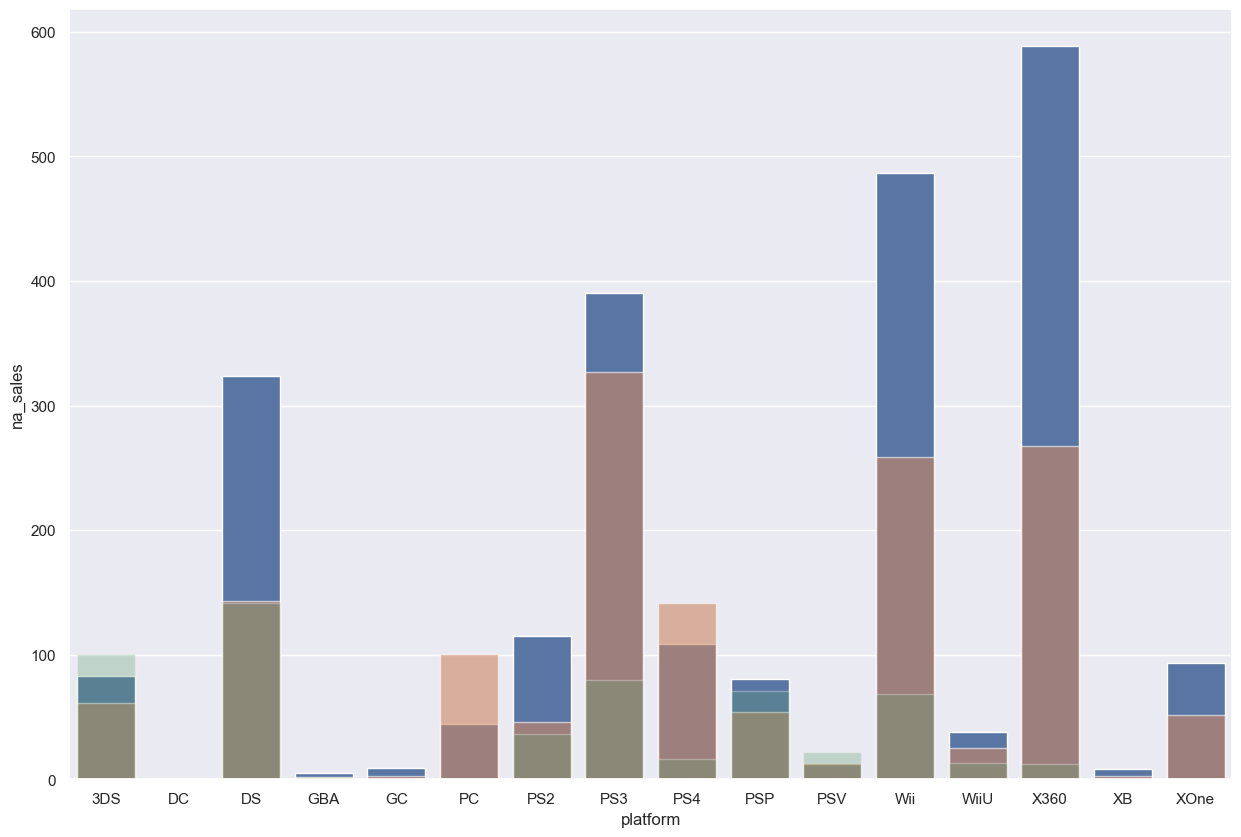

In [63]:

""" graf6 = sns.barplot(data= sales_per_plat.head(10), x="platform",y="",hue="platform")
plt.xticks(rotation=45)
graf6.set(title="Ventas totales (top 10)", xlabel='plataforma', ylabel='Ventas totales (M de USD)')
plt.show() """

dat_byReg=dat_05adv.groupby("platform")[["na_sales", "eu_sales", "jp_sales"]].sum().reset_index()


print(dat_byReg)
graf6 = sns.barplot(data= dat_byReg, x="platform",y="na_sales")
graf6 = sns.barplot(data= dat_byReg, x="platform",y="eu_sales",alpha=.6)
graf6 = sns.barplot(data= dat_byReg, x="platform",y="jp_sales",alpha=.3)

plt.show()


           genre  na_sales  eu_sales  jp_sales
0         Action    530.44    350.70    102.07
1      Adventure     61.52     37.90     29.53
2       Fighting     94.31     42.63     28.61
3           Misc    285.06    146.88     64.53
4       Platform    134.25     81.62     35.20
5         Puzzle     42.49     27.77     12.43
6         Racing    132.93    113.39     13.20
7   Role-Playing    199.63    110.62    170.38
8        Shooter    373.13    238.89     19.35
9     Simulation    107.79     69.74     23.31
10        Sports    396.64    251.55     48.97
11      Strategy     28.48     24.31     13.73


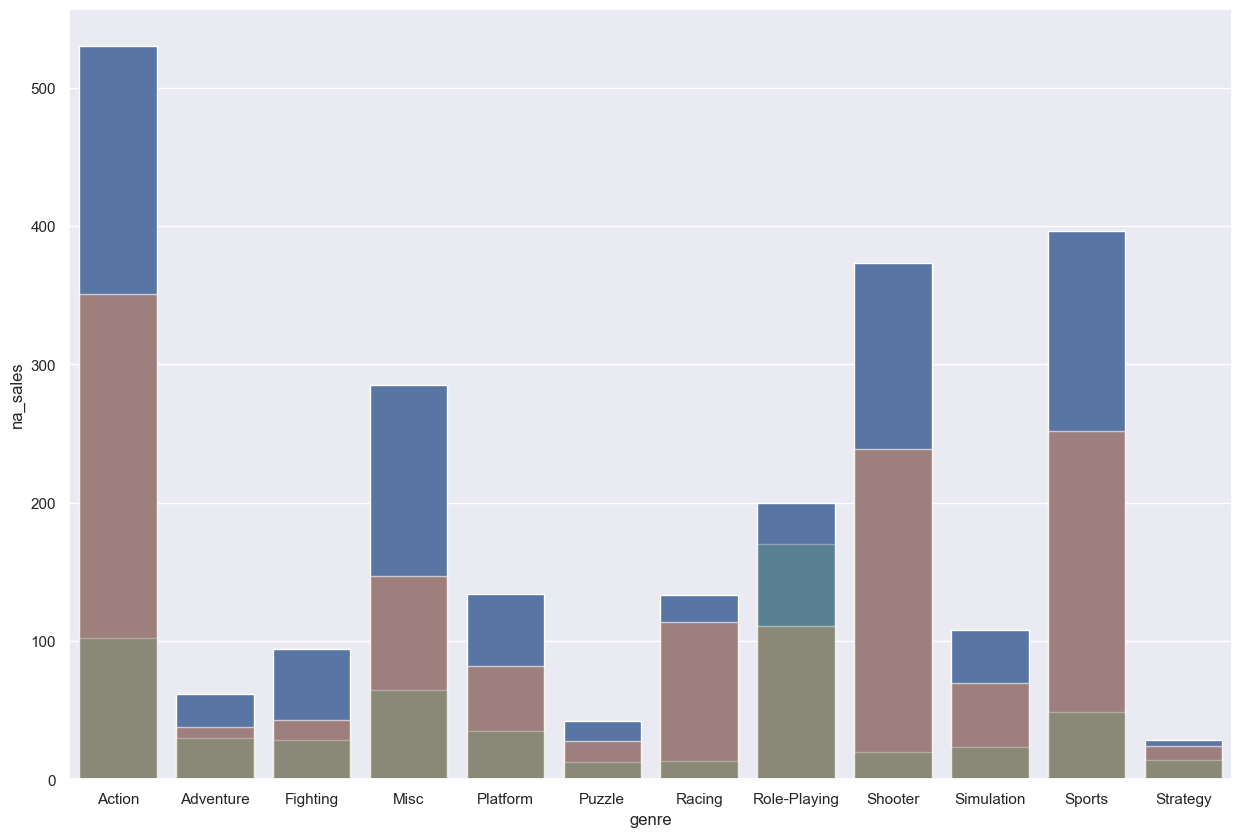

In [66]:
dat_byGen=dat_05adv.groupby("genre")[["na_sales", "eu_sales", "jp_sales"]].sum().reset_index()

print(dat_byGen)
graf6 = sns.barplot(data= dat_byGen, x="genre",y="na_sales")
graf6 = sns.barplot(data= dat_byGen, x="genre",y="eu_sales",alpha=.6)
graf6 = sns.barplot(data= dat_byGen, x="genre",y="jp_sales",alpha=.3)

plt.show()

        rating  na_sales  eu_sales  jp_sales
0  Desconocido    274.50    227.19    276.69
1            E    796.98    461.09    120.36
2         E10+    315.40    173.35     36.57
3           EC      1.32      0.00      0.00
4            M    574.33    398.90     43.79
5           RP      0.00      0.03      0.00
6            T    424.14    235.44     83.90


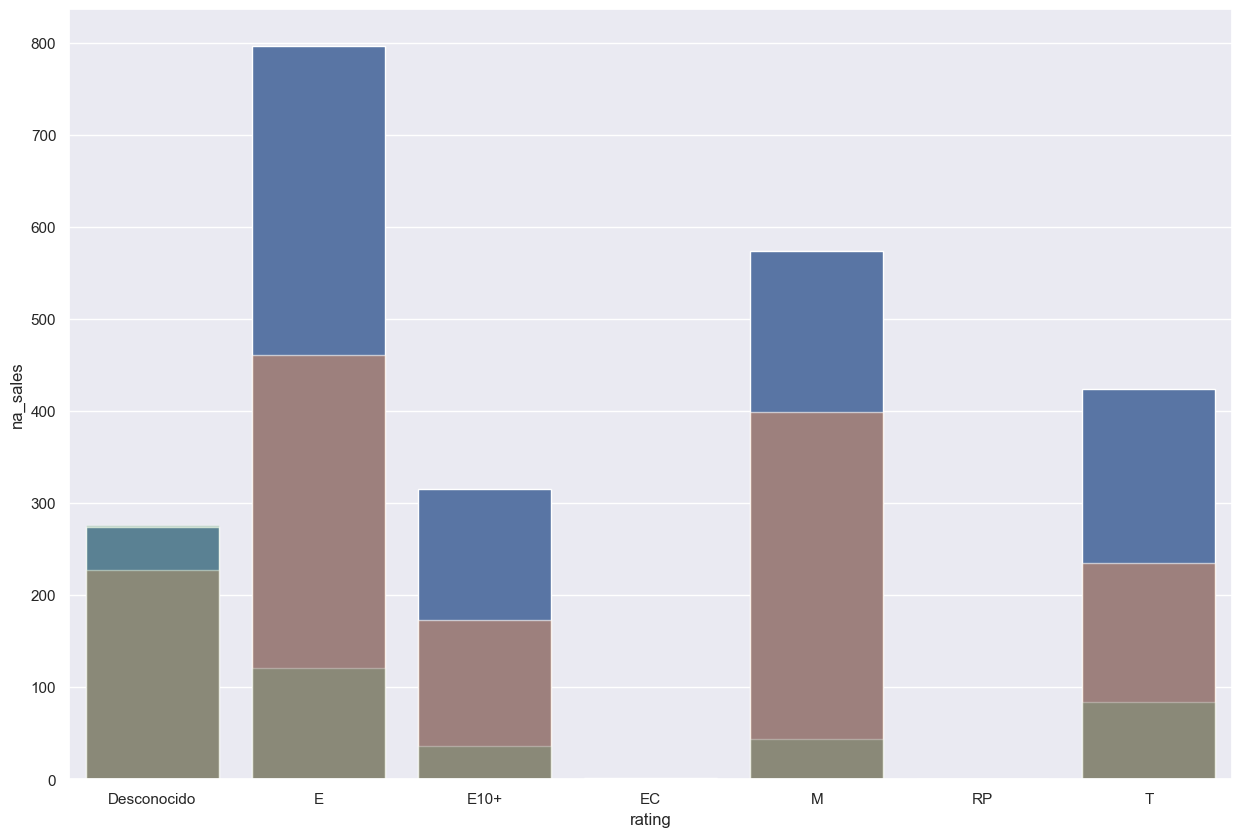

In [67]:
dat_byRating=dat_05adv.groupby("rating")[["na_sales", "eu_sales", "jp_sales"]].sum().reset_index()

print(dat_byRating)
graf7 = sns.barplot(data= dat_byRating, x="rating",y="na_sales")
graf7 = sns.barplot(data= dat_byRating, x="rating",y="eu_sales",alpha=.6)
graf7 = sns.barplot(data= dat_byRating, x="rating",y="jp_sales",alpha=.3)

plt.show()

## Paso 5
### Prueba de hipótesis:

— Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

— Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.